# Physical Models: Diffusion and Percolation
This is our week 7 examples notebook and will be available on Github from the powderflask/cap-comp215 repository.
As usual, the first code block just imports the modules we will use.

In [134]:
import math, os
from itertools import tee
import matplotlib.pyplot as plt
from matplotlib import animation, rc, lines
import numpy as np
from scipy.signal import correlate2d

if not os.path.exists('utils.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py
from Cell2D import Cell2D, draw_array

### Helpers
The Point2D class we examined in class in week 6 and a lattice random walk function for Point2D objects...


In [135]:
class Point2D:
    """ A point on the 2D Cartesian plane """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return '({x}, {y})'.format(x=round(self.x,2), y=round(self.y,2))

    def __add__(self, other):
        return Point2D(self.x+other.x, self.y+other.y)

    @property
    def r(self):
        """ length, r, from origin to this point """
        return math.sqrt(self.x**2 + self.y**2)

# N, S, E, W
CARDINAL_NEIGHBOURS = (Point2D(0,1), Point2D(0,-1), Point2D(1,0), Point2D(-1,0))

def random_walk(p):
    """ "walk" point p 1-step, to a neighbouring cardinal locaction (lattice random walk) """
    return p + np.random.choice(CARDINAL_NEIGHBOURS)

## Diffusion by "Brownian Motion"
As the length of a random walk tends to zero, it models a "Wiener process", which is a model for Brownian Motion. (https://en.wikipedia.org/wiki/Random_walk)

In the animation below, we "walk' a large set of "particles" that all start at the centre of the plane

In [136]:
class ParticleAnimation:
  """
    Animates a set of particles
  """
  def __init__(self, step, n_particles=1, show_lines=False, frames=50, figsize=(8, 8)):
    """
    :param step: a function that takes a single Point2D and returns one Point2D (presumably in next state)
    :param n_particles: number of particles to include in simulation
    :param frames: number of animation frames to generate
    """
    self.step = step
    self.ax_lim = (-frames//4, frames//4)   # particles will diffuse over wider area as animation goes on longer
    # start all particles in the centre
    self.particles = [Point2D(0, 0)for _ in range(n_particles)]
    self.radius = 0

    self.show_lines = show_lines
    self.lines = [(p, ) for p in self.particles]

    fig, self.ax = plt.subplots(figsize=figsize)
    self.animation = animation.FuncAnimation(fig, self.animate, frames=frames)

  def draw(self):
    """ Draw the particles in their current state """
    x, y = zip(*((p.x, p.y) for p in self.particles))
    self.ax.scatter(list(x), list(y), c=[i for i in range(len(x))], cmap=plt.get_cmap('tab20'))
    # fix the axes limits so they don't autoscale as particles diffuse
    self.ax.set_ylim(*self.ax_lim)
    self.ax.set_xlim(*self.ax_lim)
    # TODO: draw circle with self.radius
    if self.show_lines:
        for line in self.lines:
            x, y = zip(*((p.x, p.y) for p in line))
            self.ax.plot(x, y)

  def animate(self, step):
    """ Step the model forward and draw the ploy """
    if step > 0:
        self.particles = [self.step(p) for p in self.particles]
        self.radius = max(p.r for p in self.particles)
        self.lines = [l+(p,) for l,p in zip(self.lines, self.particles)]
    self.ax.clear()
    self.ax.set_title("Step {step}  Raidus {r}".format(step=step, r=round(self.radius)))
    self.draw()

  def show(self):
    """ return the matplotlib animation, ready for display """
    plt.close()
    rc('animation', html='jshtml')
    return self.animation


# Animate a collection of random walking particles...
n_particles = 100
frames = 50
show_lines = False

anim = ParticleAnimation(random_walk, n_particles, show_lines=show_lines, frames=frames)
anim.show()

## Percolation

Numpy arrays have some really handy capabilities.
For example, you can get an array of booleans that match some criteria, like this...

In [137]:
a = np.array((0, 1, 6, 2, 9, 4, 0, 2, 4, 7,))
a > 5

array([False, False,  True, False,  True, False, False, False, False,
        True])

and you can use an array of booleans like this to filter the array, yielding a discontinuous "slice" with only elements that meet the criteria...

In [138]:
a[a > 5]

array([6, 9, 7])

The operators ``&`` (and) and ``|`` (or) can be used build aribitrarily complex filters.  Be sure to bracket sub-expressions since the ``&`` and ``or`` operators have high precedence.

In [139]:
b = a*2
a[(a>5) & (b<15)]

array([6, 7])

In [140]:
a[(a<3) | (b>15)]

array([0, 1, 2, 9, 0, 2])

The resulting array is actually a slice of the original, so any mutation applies to the original array!!

In [141]:
a[a>5] = 5
a

array([0, 1, 5, 2, 5, 4, 0, 2, 4, 5])

## Reaction-Diffusion
In this model we have 2 "chemicals", each diffusing at their own rate.  When they mix, a chemical "reaction" occurs.
The model presented in the text introduces a number of new concepts without explaining them well, so here we'll build that model up in smaller pieces.
Note that the quantities in each cell of the CA represent "concentration" of a given chemical, between 0 and 1.


### Step 1:  2-layer diffusion
Simple: run 2 diffusion models simultaneously on same-sized grids, and overlay the 2 grids for display.  No interactions.

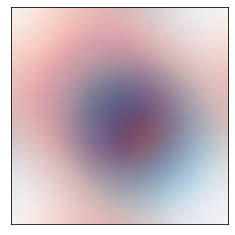

In [142]:
def add_island(a, loc=0.5, size=0.05, height=0.1):
    """ Add an island of given relative size and height at relative location in the array."""
    n, m = a.shape
    radius = int(min(n, m) * size)
    i, j = int(n*loc), int(m*loc)
    a[i-radius:i+radius, j-radius:j+radius] += height


class Diffusion2(Cell2D):
    """ Diffusion CA with 2 grids, each representing concentration of a chemical. """

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    def __init__(self, n, ra=0.5, rb=0.25, noise=0.1):
        """ Initializes nxn model with 2 chemicals, A and B, each with an island near middle """
        self.ra, self.rb = ra, rb
        self.arrayA, self.arrayB = self._setup_initial_state(n, noise)

    def _setup_initial_state(self, n, noise=0.1):
        A = np.zeros((n, n), dtype=float)
        B = np.zeros((n, n), dtype=float)
        add_island(A, loc=0.40)
        add_island(B, loc=0.60)
        return A, B

    def step(self):
        """Executes one time step."""
        A = self.arrayA
        B = self.arrayB

        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        self.arrayA += self.ra * cA
        self.arrayB += self.rb * cB

    def loop100(self):
        """ Do 100 steps to speed up the animations, which otherwise run too slowly """
        self.loop(100)

    def draw(self):
        """Draws the cells."""
        options = dict(interpolation='bicubic',
                       vmin=None, vmax=None,)
        draw_array(self.arrayA, cmap='Reds', **options)
        draw_array(self.arrayB, cmap='Blues', **options, alpha=0.5)


diffusion2 = Diffusion2(n=100)
diffusion2.animate(frames=50, step=diffusion2.loop100)

### Step 2: Add a reaction
When the two chemicals come in contact, a reaction occurs.  A simple type of reaction is that chemical A is consumed to produce more of chemical B

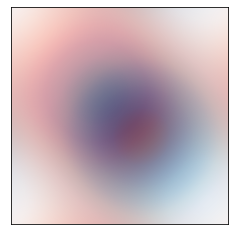

In [143]:
class SimpleReactionDiffusion(Diffusion2):
    """ Diffusion CA with 2 chemicals + a reaction term. """

    def step(self):
        """Executes one time step."""
        A = self.arrayA
        B = self.arrayB

        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        self.arrayA += self.ra * cA - reaction
        self.arrayB += self.rb * cB + reaction


simple_rd = SimpleReactionDiffusion(n=100)
simple_rd.animate(frames=50, step=simple_rd.loop100)

### Step 3: Add "feed" and "kill" rates
In biological systems, there is often a source for some chemicals (e.g. a gland that produces a hormone) and a sink (e.g., transpiration or absorbtion) for others.  In this model we "feed" chemical A and "kill" chemical B at rates ``f`` and ``k``, relative to the concentration of A and B, respectively.

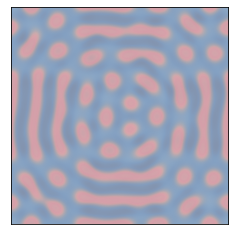

In [144]:
class ReactionDiffusion(Diffusion2):
    """ Diffusion CA with 2 chemicals + a reaction term and feed/kill rates. """

    def __init__(self, n, ra=0.5, rb=0.25, feed=0.035, kill=0.057, noise=0.1):
        super().__init__(n, ra, rb, noise=noise)
        self.f = feed
        self.k = kill
        # self.step_n=0

    def _setup_initial_state(self, n, noise=0.1):
        """ Start with high concentrations of A everywhere with an "island" of B in a sea of noise """
        # Note: this model is unstable when concentrates of A are low, likely due to simple linear feed rate
        A = np.ones((n, n), dtype=float)
        B = noise * np.random.random((n, n))
        add_island(B)
        return A, B

    def step(self):
        """Executes one time step."""
        A = self.arrayA
        B = self.arrayB

        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        # with open("out.txt", 'a') as outfile:
        #     outfile.write("Step {} : Min A{}, Max A: {}\n".format(self.step_n, np.min(A), np.max(A)))
        #     self.step_n += 1
        self.arrayA += self.ra * cA - reaction + self.f * (1-A) # feed rate increases as concentration of A falls
        self.arrayB += self.rb * cB + reaction - (self.f+self.k) * B # kill rate increases as concentration of B rises

rd = ReactionDiffusion(n=100)
rd.animate(frames=50, step=rd.loop100)

## Turing's Conjecture
In his 1952 article, [**_The Chemical Basis of Morphogenesis_**](https://dna.caltech.edu/courses/cs191/paperscs191/turing.pdf), Alan Turning proposed a hypothesis that patterns on animal hides are formed by reaction-diffusion.

This model shows how a very simple reaction-diffusion process can generate a variety of stable patterns...


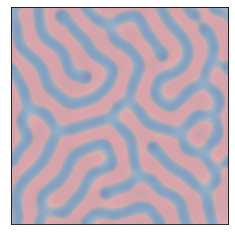

In [159]:
params = {
    'stripes' : dict(ra=0.5, rb=0.25, feed=0.035, kill=0.057),
    'coral'   : dict(ra=0.5, rb=0.25, feed=0.055, kill=0.062),
    'spots'   : dict(ra=0.5, rb=0.25, feed=0.039, kill=0.065),
    'test'    : dict(ra=0.5, rb=0.25, feed=0.037, kill=0.060),
}

pattern = 'test'
rd = ReactionDiffusion(n=100, **params[pattern])
rd.animate(frames=50, step=rd.loop100)